# Content

>[Content](#scrollTo=36GuAqfCX9Jn)

>[Task](#scrollTo=C-iwFUKiqEtj)

>[Additional lins](#scrollTo=WIlABSUw8dcp)

>[I Libraries and Functions](#scrollTo=FFeHm5fJ8c3Q)

>>[1 Importing libraries](#scrollTo=3Hi7SeJvcR1r)

>>[2 Definition of functions](#scrollTo=S-5A_f44RvG8)

>>[3 Load dataset](#scrollTo=Py1KbSvDPske)

>>[4 Review dataset](#scrollTo=3E2b12ghP08w)

>>>[4.1 Review target value](#scrollTo=PmFJLfQ0PkNr)

>>>[4.2 Visualisation of features (histogram)](#scrollTo=XlwAEWZHbYxo)

>>>[4.3 Correlation of features with the target variable](#scrollTo=lHz7-4qXboAv)

>>>[4.4 Matrix of correlations](#scrollTo=GHjA3OTmb_RZ)

>>>[4.5 Getting important features for build model](#scrollTo=sW-7sNJ8acci)

>>[5 Split dataset](#scrollTo=F93oUScuc5X7)

>>>[5.1 Split features on binary, categorical and scaler](#scrollTo=7kK_B68Za9_s)

>>>[5.2 Splir dataset](#scrollTo=n3r6yyndbLUG)

>>[6 Learning models](#scrollTo=2YenMQWLqkqC)

>>>[6.1 Definition list of models](#scrollTo=g2jo-OuDYyg9)

>>>[6.2 Definition of params for models](#scrollTo=btbfBQ4FYfIV)

>>>[6.3 Learning LogReg model](#scrollTo=l5y2AXVlZAu2)

>>>>[6.3.1 Save and load model](#scrollTo=PsKE5f6MbU8D)

>>>[6.4 Getting predictions](#scrollTo=weOAlZXlZKM0)

>>[7 Visualisation of resalts](#scrollTo=KVpb4k0C3lDB)

>>[8 The importance of features](#scrollTo=BZ9Or0aCFAxA)

>>[9 Visualisation results with SHAP](#scrollTo=GvlabLqvTIRH)



# Task

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


# Additional lins

- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value
- Regular expression operations - https://docs.python.org/3.8/library/re.html
- https://media.tproger.ru/user-uploads/33794/2023-12-20/b7899beb-e245-46fd-9f94-e1721cb810be.png

# I Libraries and Functions

## 1 Importing libraries


In [1]:
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [133]:
from google.colab import drive, files
import re
import os
import shutil
import shap
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
    confusion_matrix, roc_auc_score, precision_score, classification_report, recall_score, accuracy_score, \
        r2_score

## 2 Definition of functions

In [128]:
star = lambda x:"\n" + x*50 + "\n"

def Mkdir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

def HIST (DF, b=50, w=16, h=8):
    DF.hist(figsize=(w, h), bins=b, grid=False);

def Cross_Vall(DF, t=0.3):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.2)

    corr_matrix = DF.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < t] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()

def Graff(col1, col2, w=9, h=9):
    '''col1 and col2: like as df['name_col']'''
    grid = sns.jointplot(x=col1, y=col2, kind='reg')
    grid.fig.set_figwidth(w)
    grid.fig.set_figheight(h)
    plt.show()

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def get_feature_names_out(self, feature_names_out):
        return self.columns

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, dtype=np.int8)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


def Learning_model(ppln : "Pipeline", clsfr_param : dict, model, x_train, y_train):
    print(model.__name__)
    ppln.steps.append(('clf', model(random_state=42, **clsfr_param[model.__name__])))
    ppln.verbose = True
    ppln.fit(x_train, y_train)
    return ppln

def save_model(path, model_name):
    with open(path, "wb") as mod:
        pickle.dump(model_name, mod)


def load_model(path):
    with open(path, "rb") as mod1:
        model_name = pickle.load(mod1)
    return model_name

def ROC_AUC_show(y_test, y_true):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()


def Calc_of_metrics_and_Roc_Auc(model, X_train, X_test, y_train, y_test, y_true_proba, y_true_predict):
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test, y_true_proba)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(fscore)
    if np.isnan(fscore[ix]):
        F1 = f1_score(y_test, y_true_predict)
        closest_value = min(fscore, key=lambda x: abs(F1 - x))
        ix = list(fscore).index(closest_value)
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true_proba, pos_label=1)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    print("\n","*"*50,"\n")
    ROC_AUC_show(y_test, y_true_proba)

    print("\n","*"*50,"\n")
    print(f"ROC_AUC score train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
    print(f"ROC_AUC score test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
    metrics_dict = {"Thresholds_ix":thresholds[ix], "F_score_ix": fscore[ix],
                    "Precision_ix":precision[ix], "Recall_ix": recall[ix],
                    "Thresholds":thresholds, "F_score": fscore,
                    "Precision":precision, "Recall": recall}
    return metrics_dict, ix


def plot_precision_recall(metrics : dict, model):
    print(model.named_steps["clf"].__class__.__name__)
    plt.plot(metrics['Recall'], metrics['Precision'])
    plt.plot(metrics['Recall_ix'], metrics['Precision_ix'], "o", c="r", ms=10)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.annotate(f"Recall = {round(metrics['Recall_ix'], 2)},\nPrecision = {round(metrics['Precision_ix'], 2)}",
                xy=(metrics['Recall_ix'], metrics['Precision_ix']))
    plt.show()


def Data_important_features(model) -> dict:
    feature_names = list(model.named_steps['features'].get_feature_names_out())

    if hasattr(model.named_steps['clf'], 'feature_importances_'):
        feature_coeff = model.named_steps['clf'].feature_importances_
    else:
        feature_coeff = model.named_steps['clf'].coef_[0]

    feature_importance = pd.DataFrame({'feature_name': feature_names,
                                    'feature_score': feature_coeff
                                    }).sort_values('feature_score', ascending=False).reset_index(drop=True)

    feature_importance["feature_name"] = feature_importance["feature_name"].apply(lambda x: re.sub('_\w*', '', x))

    plt.figure(figsize=(6, 6))
    sns.barplot(data=feature_importance, y='feature_name', x='feature_score')
    plt.ylabel("Features")
    plt.xlabel("Coefficients")
    plt.title(f"The importance of features ({model.named_steps['clf'].__class__.__name__})")
    plt.show()

    return feature_importance

## 3 Load dataset

In [5]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
path_to_work_dir = "/content/drive/MyDrive/HW7_MOB/"

In [ ]:
# Mkdir(path_to_work_dir)

In [ ]:
# new_file = files.upload()

In [ ]:
# shutil.move("/content/archive.zip", path_to_work_dir)

In [ ]:
# os.listdir(path_to_work_dir)

In [ ]:
# !unzip "/content/drive/MyDrive/HW7_MOB/archive.zip" -d "/content/drive/MyDrive/HW7_MOB/"

In [7]:
os.listdir(path_to_work_dir)

['heart_disease_health_indicators_BRFSS2015.csv',
 '.ipynb_checkpoints',
 'archive.zip',
 'LogReg_model.pkl']

In [8]:
df = pd.read_csv(path_to_work_dir + "heart_disease_health_indicators_BRFSS2015.csv")

## 4 Review dataset

In [9]:
df.shape

(253680, 22)

In [10]:
df.head(7)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0


### 4.1 Review target value

In [11]:
target = "HeartDiseaseorAttack"

In [12]:
df[target].value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### 4.2 Visualisation of features (histogram)

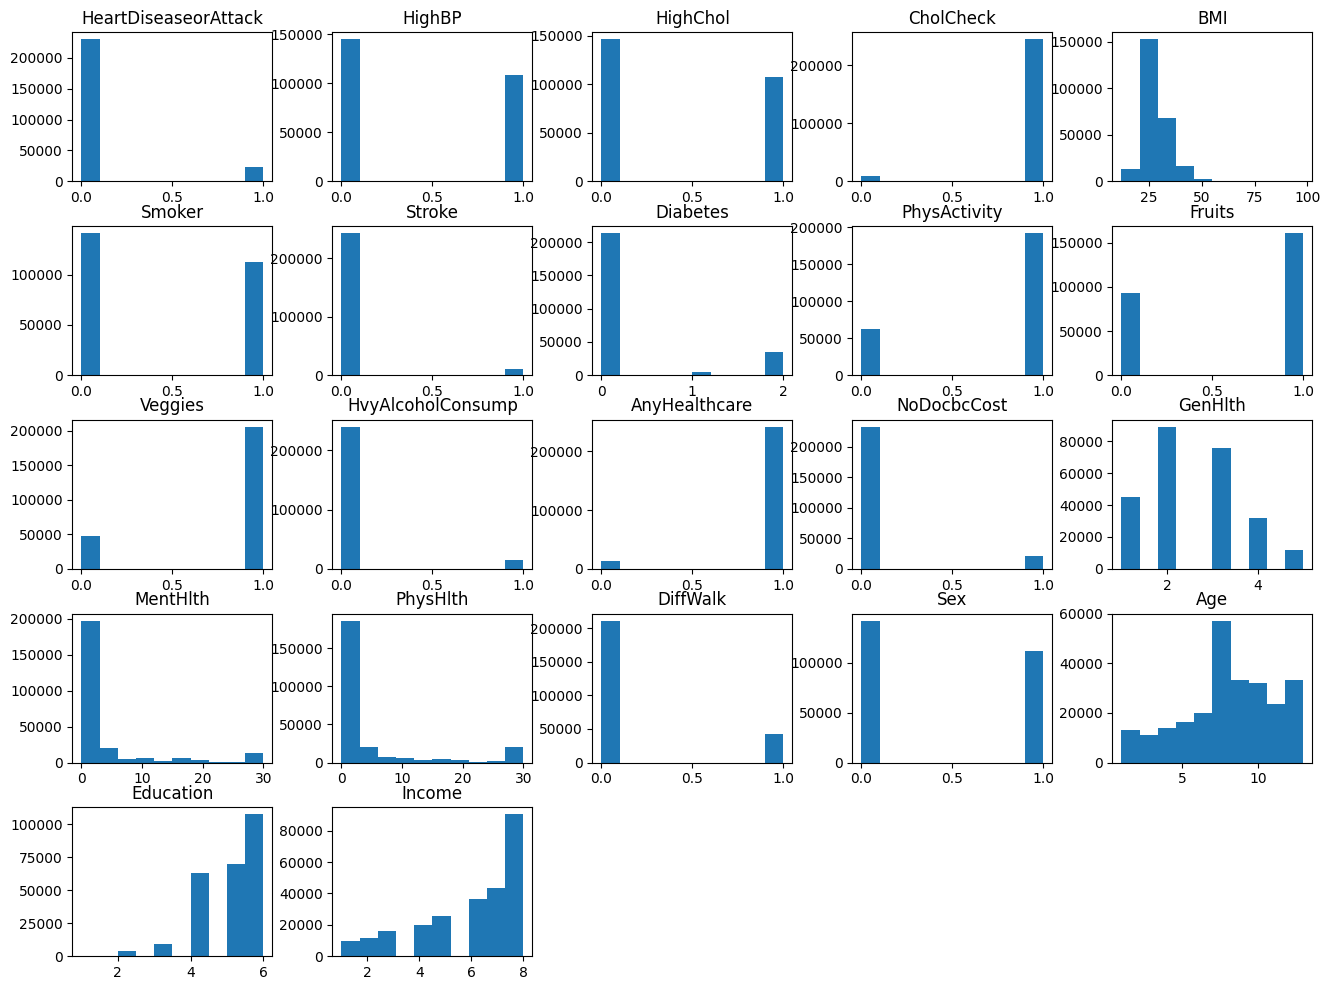

In [14]:
HIST(df, b=10, h=12)

### 4.3 Correlation of features with the target variable

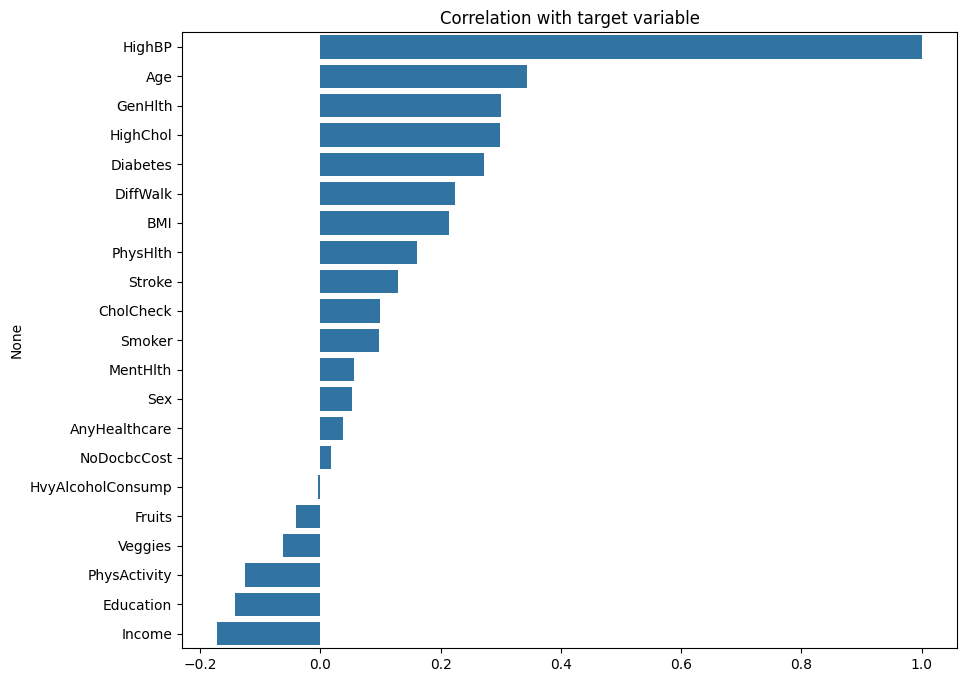

In [15]:
corr_with_target = df.corr().iloc[1:,1].sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

### 4.4 Matrix of correlations

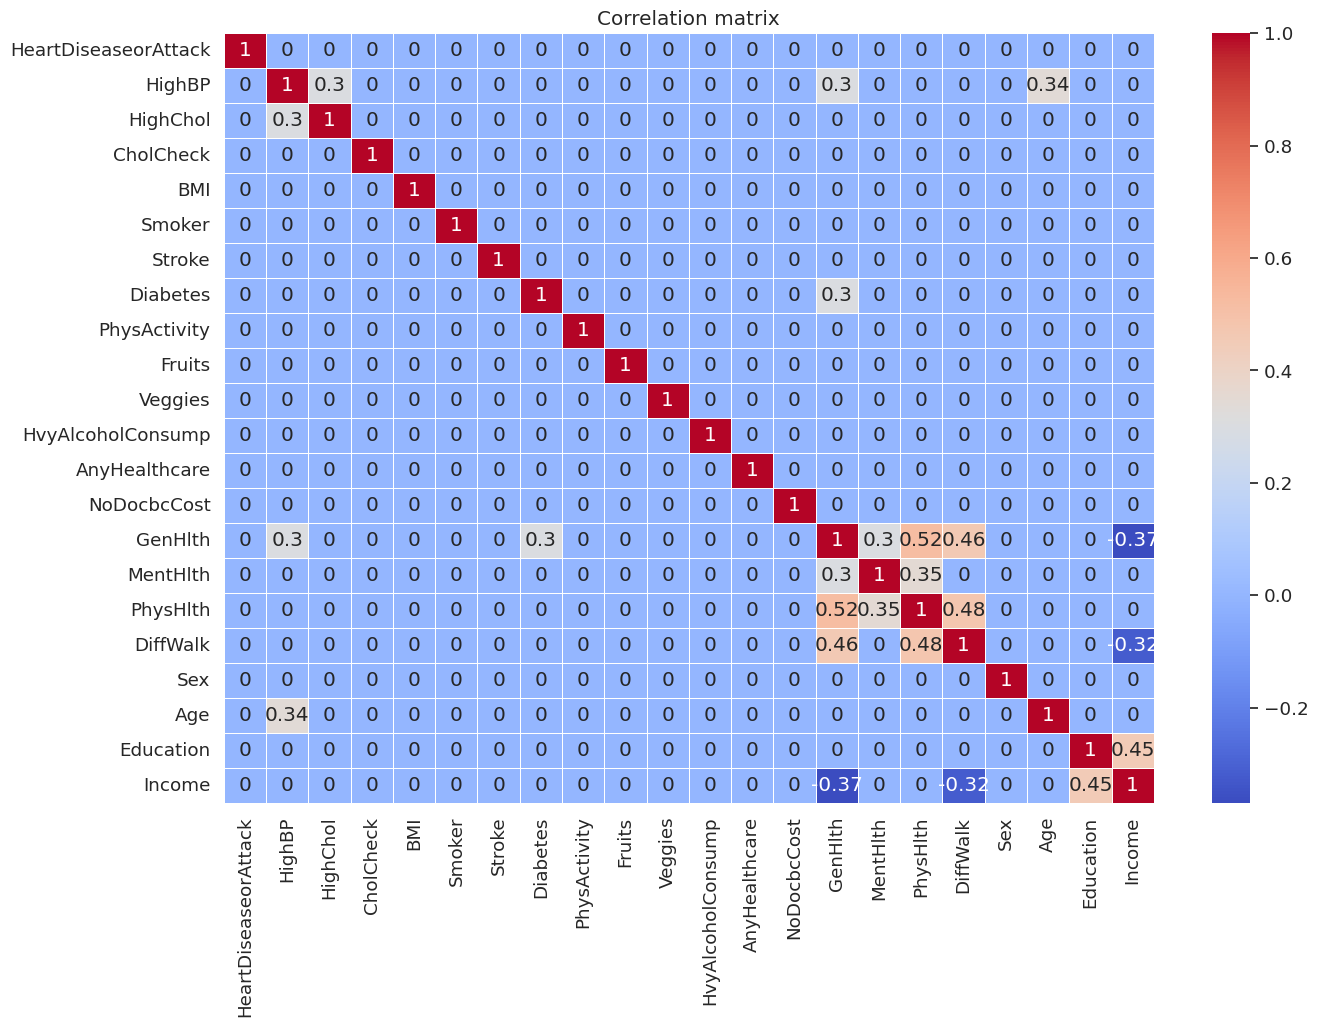

In [16]:
Cross_Vall(df, t=0.3)

### 4.5 Getting important features for build model

In [17]:
df_corr_matrix = df.corr()
df_corr_matrix = np.round(df_corr_matrix, 2)
df_corr_matrix = df_corr_matrix[np.abs(df_corr_matrix) > 0.3]
df_corr_matrix[df_corr_matrix == 1] = None

In [18]:
feature_importants = df_corr_matrix.isna().sum()[df_corr_matrix.isna().sum().values < 22].index
feature_importants

Index(['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age',
       'Education', 'Income'],
      dtype='object')

In [19]:
feature_importants = feature_importants.drop("Education")
feature_importants

Index(['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age',
       'Income'],
      dtype='object')

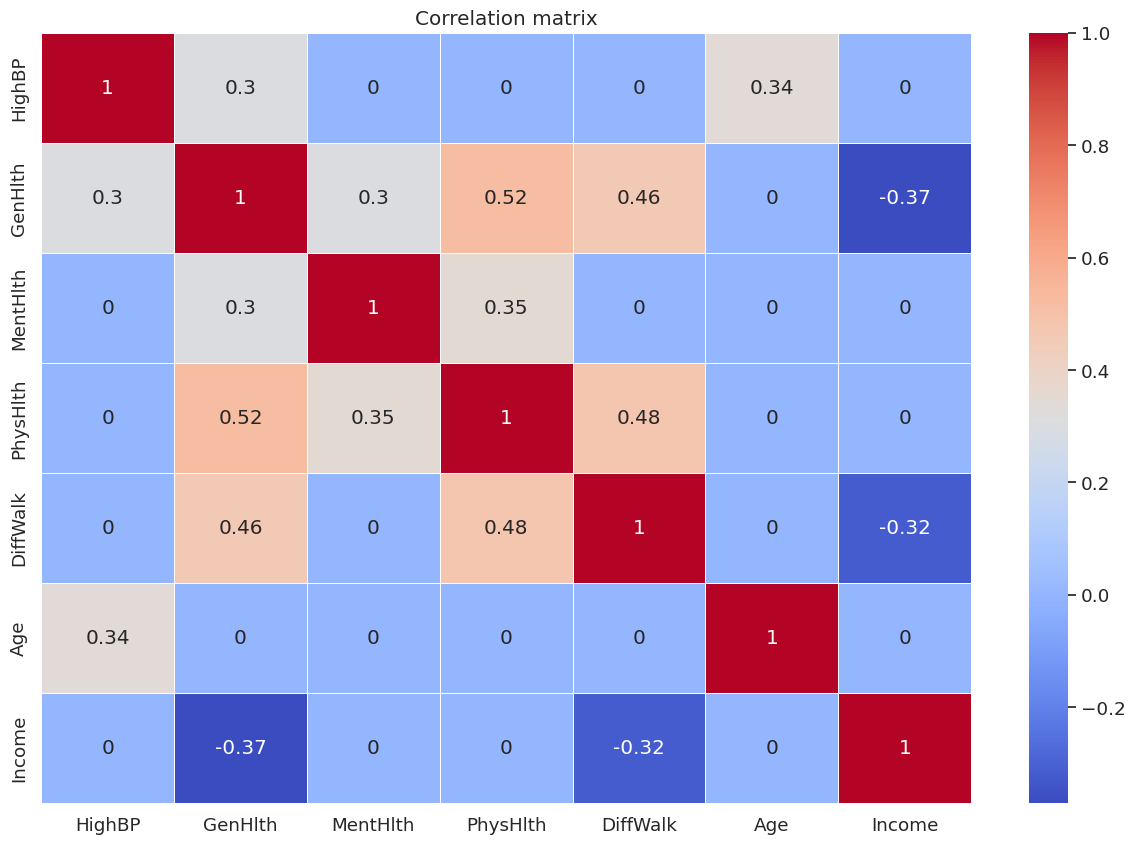

In [20]:
Cross_Vall(df[feature_importants], t=0.3)

## 5 Split dataset

In [21]:
for col in feature_importants:
    print(col, "\n\n", df[col].value_counts().index)
    print(star("*"))

HighBP 

 Float64Index([0.0, 1.0], dtype='float64')

**************************************************

GenHlth 

 Float64Index([2.0, 3.0, 1.0, 4.0, 5.0], dtype='float64')

**************************************************

MentHlth 

 Float64Index([ 0.0,  2.0, 30.0,  5.0,  1.0,  3.0, 10.0, 15.0,  4.0, 20.0,  7.0,
              25.0, 14.0,  6.0,  8.0, 12.0, 28.0, 21.0, 29.0, 18.0,  9.0, 16.0,
              27.0, 22.0, 17.0, 26.0, 11.0, 13.0, 23.0, 24.0, 19.0],
             dtype='float64')

**************************************************

PhysHlth 

 Float64Index([ 0.0, 30.0,  2.0,  1.0,  3.0,  5.0, 10.0, 15.0,  4.0,  7.0, 20.0,
              14.0, 25.0,  6.0,  8.0, 21.0, 12.0, 28.0, 29.0,  9.0, 18.0, 16.0,
              27.0, 17.0, 24.0, 22.0, 26.0, 13.0, 11.0, 23.0, 19.0],
             dtype='float64')

**************************************************

DiffWalk 

 Float64Index([0.0, 1.0], dtype='float64')

**************************************************

Age 

 Float64Index

### 5.1 Split features on binary, categorical and scaler

In [22]:
binary_feature = ["HighBP", "DiffWalk"]
categorical_feature = ["GenHlth"]
scaler_feature = [e for e in feature_importants if e not in binary_feature + categorical_feature]

### 5.2 Splir dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_importants], df[target],
                                                    test_size=0.3, stratify=df[target],
                                                    random_state=42)

## 6 Learning models

### 6.1 Definition list of models

In [24]:
classifier_list = [XGBClassifier, CatBoostClassifier,
                   RandomForestClassifier, DecisionTreeClassifier,
                   LogisticRegression]

In [25]:
TRANSFORMERS = []

for col in binary_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col))])))

for col in scaler_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))

for col in categorical_feature:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('ohe', OHEEncoder(key=col))])))

In [26]:
vc = y_train.value_counts()
scale_pos_weight = int(vc[0] / vc[1])

### 6.2 Definition of params for models

In [27]:
clf_params = {
    'CatBoostClassifier': {
        'loss_function': 'Logloss',
        'auto_class_weights': 'Balanced',
        'depth': 6,
        'iterations': 300,
        'learning_rate': 0.01,
        'eval_metric': 'AUC',
        'verbose': 200
    },
    'XGBClassifier': {
        'verbosity': 1,
        'max_depth': 5,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform', # 'gradient_based', 'uniform'
        'scale_pos_weight': scale_pos_weight
    },
    'RandomForestClassifier': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'gini',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    },
    'DecisionTreeClassifier': {
        'criterion': 'gini',
        'max_depth': 7,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'class_weight': 'balanced',

    },
    'LogisticRegression': {
        'max_iter': 1000,
        'class_weight': 'balanced', # {0:1, 1:10}
        'fit_intercept': True,
        'penalty': 'l2'
    }
}

In [28]:
PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])

### 6.3 Learning LogReg model

In [ ]:
model_logreg = Learning_model(PIPELINE, clf_params, LogisticRegression, X_train, y_train)

LogisticRegression
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.6s


In [ ]:
model_logreg

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('HighBP',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HighBP'))])),
                                                ('DiffWalk',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='DiffWalk'))])),
                                                ('MentHlth',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='MentHlth')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('PhysHlth',
                                                 Pipeline(steps=[('selector'...
                                                                  FeatureSelector(key='Age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('Income',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='Income')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('GenHlth',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='GenHlth')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='GenHlth'))]))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))],
         verbose=True)

#### 6.3.1 Save and load model

In [ ]:
# save_model(path_to_work_dir + "LogReg_model.pkl", model_logreg)

In [31]:
load_logreg_model = load_model(path_to_work_dir + "LogReg_model.pkl")

### 6.4 Getting predictions

In [32]:
y_test_proba = load_logreg_model.predict_proba(X_test)[:,1]
y_test_pred = load_logreg_model.predict(X_test)

## 7 Visualisation of resalts

Best Threshold=0.672, F-Score=0.377, Precision=0.285, Recall=0.557

 ************************************************** 



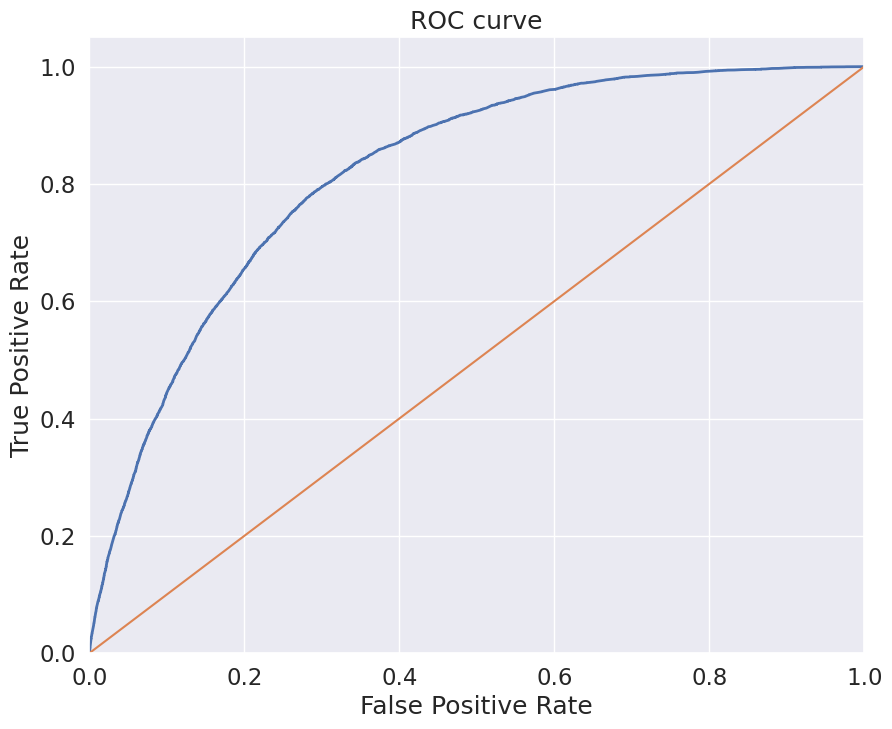


 ************************************************** 

ROC_AUC score train: 0.8187267927975642
ROC_AUC score test: 0.818956120920647


In [33]:
metrics_logreg, idx = Calc_of_metrics_and_Roc_Auc(load_logreg_model, X_train, X_test,
                                             y_train, y_test, y_test_proba, y_test_pred)

LogisticRegression


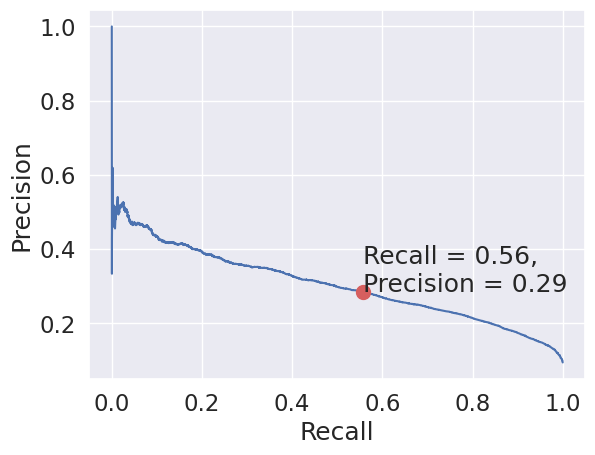

In [56]:
plot_precision_recall(metrics_logreg, load_logreg_model)

## 8 The importance of features

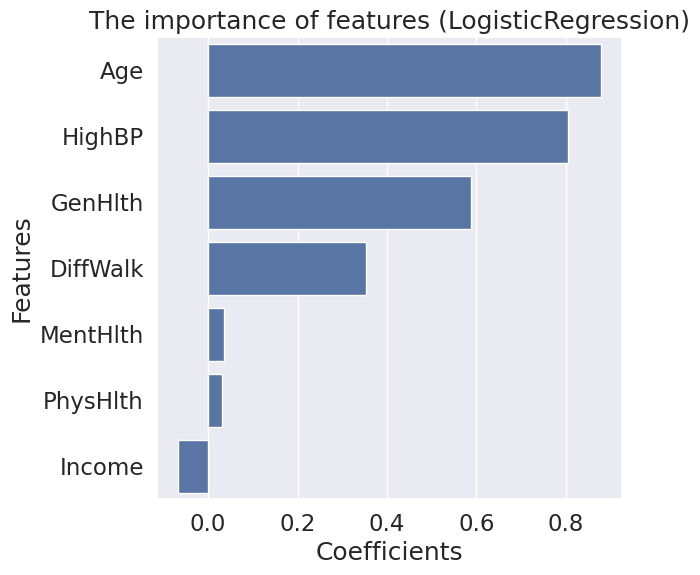

In [129]:
feature_importance_logreg = Data_important_features(load_logreg_model)

In [130]:
feature_importance_logreg

,feature_name,feature_score
0,Age,0.878673
1,HighBP,0.804766
2,GenHlth,0.587800
3,DiffWalk,0.353381
4,MentHlth,0.035816
5,PhysHlth,0.030402
6,Income,-0.066933


## 9 Visualisation results with SHAP

In [136]:
if load_logreg_model.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
    explainer = shap.LinearExplainer(load_logreg_model.named_steps['clf'], X_test)
else:
    explainer = shap.TreeExplainer(load_logreg_model.named_steps['clf'], X_test)


sh_values = explainer.shap_values(X_test)

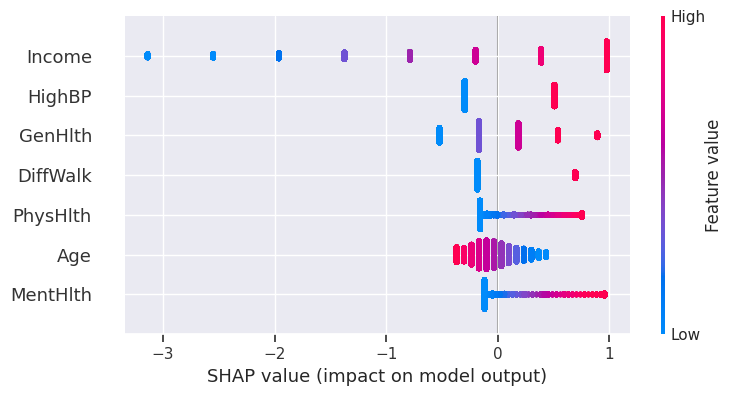

In [137]:
shap.initjs()
shap.summary_plot(sh_values, X_test)

In [142]:
shap.initjs()
pos = 443
shap.force_plot(explainer.expected_value, sh_values[pos,:], X_test.iloc[pos,:])